In [1]:
import numpy as np
import tensorflow as tf
import tensorpack as tp

In [2]:
import tensorflow as tf
import tensorflow.contrib.slim as slim

def depthwise_conv2d_splite(input_tensor, kernel_size, strides=[1, 1], padding='VALID', activation_fn=None, scope=None):
    axis = 3
    shape = [-1] + [int(s) for s in input_tensor.shape[1:]]

    splited = [tf.reshape(t, [shape[0], shape[1], shape[2], 1]) for t in tf.unstack(input_tensor, axis=axis)]
    
    splited_out = []
    for i, t in enumerate(splited):
        o = slim.layers.conv2d(t, 1, [3, 3], activation_fn=activation_fn, scope=scope, reuse=(i>0))
        splited_out.append(tf.reshape(o, [shape[0], shape[1], shape[2]]))
    
    result = tf.stack(splited_out, axis=axis)
    return result

def depthwise_conv2d_permutate(input_tensor, kernel_size, strides=[1, 1], padding='VALID', activation_fn=None, scope=None):
    axis = 3
    shape = [-1] + [int(s) for s in input_tensor.shape[1:]]
    
    permuated = tf.reshape(tf.transpose(input_tensor, perm=[0, 3, 1, 2]), [-1, shape[1], shape[2], 1])
    output = slim.layers.conv2d(permuated, 1, [3, 3], activation_fn=activation_fn, scope=scope)
    new_shape = [-1] + [int(s) for s in output.shape[1:]]
    result = tf.transpose(tf.reshape(output, [-1, shape[3], new_shape[1], new_shape[2]]), perm=[0, 2, 3, 1])

    return result

depthwise_conv2d = depthwise_conv2d_splite


def pointwise_conv2d(input_tensor, filters, activation_fn=None, scope=None):
    return slim.layers.conv2d(input_tensor, filters, [1, 1], padding='SAME', activation_fn=activation_fn, scope=scope)

In [3]:
import time
import cv2
import numpy as np
import tensorflow as tf
import tensorpack as tp

from tensorpack import dataset
from tensorpack.dataflow import imgaug, AugmentImageComponent, BatchData, PrefetchData
import tensorpack.tfutils.symbolic_functions as symbf

import tensorflow.contrib.slim as slim
from tensorflow.python.framework import ops
from tensorflow.python.training import optimizer

class ModelMNIST10x10_simple(object):
    def __init__(self, learning_rate=0.001, batch_size=128):
        self.batch_size = batch_size
        self.inputs = [
            tf.placeholder(tf.float32, shape=(None, 10, 10, 1)),
            tf.placeholder(tf.int32, shape=(None,)),
            tf.placeholder(tf.float32, shape=(None, 10))
        ]
        
        self.probability, self.cost, self.accuracy = self._build_graph(self.inputs)
        self.op = self._get_optimize_operator(self.cost, learning_rate)
        self.dataflow = {
            'train':self._get_data('train'),
            'valid':self._get_data('test'),
        }
        
    def _build_graph(self, inputs):
        image, label, vector = inputs
        
        with slim.arg_scope([slim.layers.separable_conv2d], weights_regularizer=slim.l2_regularizer(1e-4), activation_fn=tf.nn.relu), \
             slim.arg_scope([slim.layers.fully_connected], weights_regularizer=slim.l2_regularizer(1e-5)):
            l = image
            l = depthwise_conv2d(l, [3, 3], padding='SAME', scope='conv0_depthwise')
            l = pointwise_conv2d(l, 8, activation_fn=tf.nn.relu, scope='conv0_pointwise')
            #l = slim.layers.conv2d(l, 8, [3, 3], padding='SAME', scope='conv0' ) # 10x10
            l = slim.layers.max_pool2d(l, [2, 2], scope='pool0') # 5x5
            l = depthwise_conv2d(l, [3, 3], padding='VALID', scope='conv1_depthwise')
            l = pointwise_conv2d(l, 8, activation_fn=tf.nn.relu, scope='conv1_pointwise')
            l = depthwise_conv2d(l, [3, 3], padding='VALID', scope='conv2_depthwise')
            l = pointwise_conv2d(l, 8, activation_fn=tf.nn.relu, scope='conv2_pointwise')
            l = slim.layers.flatten(l, scope='flatten')
            logits = slim.layers.fully_connected(l, 10, activation_fn=None, scope='fc0')

        # Currently there is no way to take the second derivative of sparse_softmax_cross_entropy_with_logits due to the fused implementation
        #cost = tf.nn.sparse_softmax_cross_entropy_with_logits(logits=logits, labels=label)
        cost = tf.nn.sigmoid_cross_entropy_with_logits(logits=logits, labels=vector)
        cost = tf.reduce_mean(cost, name='cross_entropy_loss')

        prob = tf.nn.softmax(logits, name='prob')
        accuracy = symbf.accuracy(logits, label, topk=1)
        return prob, cost, accuracy
    
    def _get_optimize_operator(self, cost, learning_rate=1.0):
        var_list = (tf.trainable_variables() + tf.get_collection(tf.GraphKeys.TRAINABLE_RESOURCE_VARIABLES))
        var_list += tf.get_collection(tf.GraphKeys._STREAMING_MODEL_PORTS)

        processors = [optimizer._get_processor(v) for v in var_list]
        var_refs = [p.target() for p in processors]

        # compute_gradients
        grads = tf.gradients(
                cost, var_refs,
                grad_ys=None, aggregation_method=None, colocate_gradients_with_ops=True)
        grads_and_vars = list(zip(grads, var_list))

        self.grads = grads
        opt = tf.train.AdamOptimizer(learning_rate)
        return opt.apply_gradients(grads_and_vars)
    
    def _get_data(self, train_or_test):
        BATCH_SIZE = self.batch_size
        isTrain = train_or_test == 'train'
        ds = dataset.Mnist(train_or_test)
        if isTrain:
            augmentors = [
                #imgaug.RandomApplyAug(imgaug.RandomResize((0.8, 1.2), (0.8, 1.2)), 0.3),
                #imgaug.RandomApplyAug(imgaug.RotationAndCropValid(15), 0.5),
                #imgaug.RandomApplyAug(imgaug.SaltPepperNoise(white_prob=0.01, black_prob=0.01), 0.25),
                imgaug.Resize((10, 10)),
                imgaug.CenterPaste((12, 12)),
                imgaug.RandomCrop((10, 10)),
                imgaug.MapImage(lambda x: x.reshape(10, 10, 1))
            ]
        else:
            augmentors = [
                imgaug.Resize((10, 10)),
                imgaug.MapImage(lambda x: x.reshape(10, 10, 1))
            ]
        ds = AugmentImageComponent(ds, augmentors)
        ds = BatchData(ds, BATCH_SIZE, remainder=not isTrain)
        if isTrain:
            ds = PrefetchData(ds, 3, 2)
        return ds

In [4]:
model = ModelMNIST10x10_simple(batch_size=128*100)

[1024 16:38:29 @fs.py:89] WRN Env var $TENSORPACK_DATASET not set, using /root/tensorpack_data for datasets.


In [5]:
sess = tf.Session()
sess.run(tf.global_variables_initializer())
print('session initialized')

session initialized


In [6]:
import sklearn.preprocessing

history = []
for epoch in range(30):
    result = {}
    
    model.dataflow['train'].reset_state()
    step, costs, accuracies = 0, [], []
    
    timestamp = time.time()
    for datapoint in model.dataflow['train'].get_data():
        datapoint.append( sklearn.preprocessing.label_binarize( datapoint[1], range(10) ).astype(np.float32) )
        _, cost, accuracy, grads = sess.run([model.op, model.cost, model.accuracy, model.grads],
                                     feed_dict=dict(zip(model.inputs, datapoint)))
        grads = [np.sum(np.abs(g)) for g in grads]
        costs.append(cost)
        accuracies.append(accuracy)
        step += 1
    eplapsed = time.time() - timestamp
    print('[%04d] [train] cost:%.3f accuracy:%0.3f elapsed:%.3fs'%(epoch+1, np.mean(costs), np.mean(accuracies), eplapsed), end=' ')
    result['train'] = {'epoch':epoch, 'cost':np.mean(costs), 'accuracy':np.mean(accuracies), 'grads_abs':grads}

    model.dataflow['valid'].reset_state()
    costs, accuracies = [], []
    timestamp = time.time()
    for datapoint in model.dataflow['valid'].get_data():
        datapoint.append( sklearn.preprocessing.label_binarize( datapoint[1], range(10) ).astype(np.float32) )
        cost, accuracy = sess.run([model.cost, model.accuracy],
                                     feed_dict=dict(zip(model.inputs, datapoint)))
        costs.append(cost)
        accuracies.append(accuracy)
    eplapsed = time.time() - timestamp
    print('[valid] cost:%.3f accuracy:%0.3f elapsed:%.3fs'%(np.mean(costs), np.mean(accuracies), eplapsed))
    result['valid'] = {'epoch':epoch, 'cost':np.mean(costs), 'accuracy':np.mean(accuracies)}
    
    history.append( result )

[0001] [train] cost:0.661 accuracy:0.125 elapsed:1.953s [valid] cost:0.642 accuracy:0.133 elapsed:0.357s
[0002] [train] cost:0.634 accuracy:0.130 elapsed:0.590s [valid] cost:0.612 accuracy:0.132 elapsed:0.310s
[0003] [train] cost:0.603 accuracy:0.129 elapsed:1.739s [valid] cost:0.577 accuracy:0.131 elapsed:0.315s
[0004] [train] cost:0.568 accuracy:0.127 elapsed:1.410s [valid] cost:0.539 accuracy:0.129 elapsed:0.296s
[0005] [train] cost:0.528 accuracy:0.131 elapsed:2.078s [valid] cost:0.497 accuracy:0.129 elapsed:0.352s
[0006] [train] cost:0.486 accuracy:0.136 elapsed:1.378s [valid] cost:0.454 accuracy:0.129 elapsed:0.293s
[0007] [train] cost:0.444 accuracy:0.134 elapsed:2.237s [valid] cost:0.414 accuracy:0.129 elapsed:0.295s
[0008] [train] cost:0.406 accuracy:0.135 elapsed:1.596s [valid] cost:0.379 accuracy:0.131 elapsed:0.292s
[0009] [train] cost:0.374 accuracy:0.136 elapsed:2.371s [valid] cost:0.354 accuracy:0.135 elapsed:0.289s
[0010] [train] cost:0.352 accuracy:0.139 elapsed:1.667s

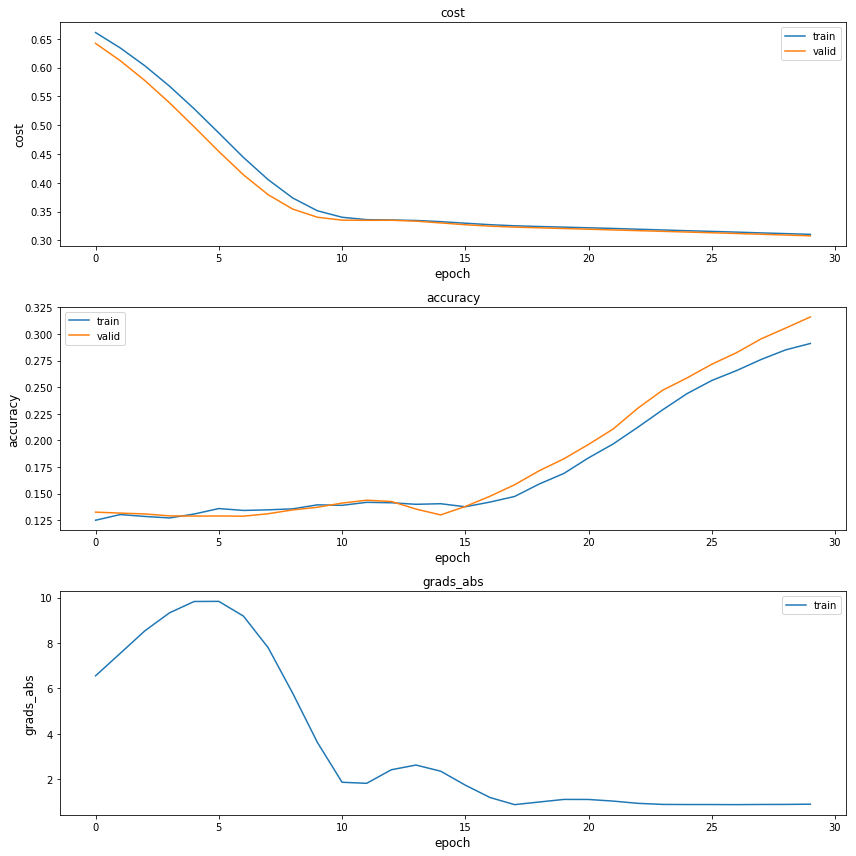

In [7]:
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline

fig = plt.figure(figsize=(12, 4*3))
for i, label in enumerate(['cost', 'accuracy', 'grads_abs']):
    ax = fig.add_subplot(3, 1, i+1)
    ax.set_xlabel('epoch', fontsize=12)
    ax.set_ylabel(label, fontsize=12)
    ax.set_title(label, fontsize=12)
    for j, mode in enumerate(['train', 'valid']):
        if not label in history[0][mode]:
            continue
        ax.plot(np.array([h[mode]['epoch'] for h in history]), np.array([np.sum(h[mode][label]) for h in history]), label=mode)
    ax.legend()
plt.tight_layout()